The goal of this notebook is to demonstrate how you and other members of your organization can use W&B Registry to track, share, and use dataset and model artifacts in your machine learning workflows. By the end of this notebook, you will know how to use W&B to:

1. Create [collections](https://docs.wandb.ai/guides/registry/create_collection) within the [Dataset and Model registry](https://docs.wandb.ai/guides/registry/registry_types#core-registry).
2. Make dataset and model artifacts available to other members of your organization, and
3. Download our trained model and dataset artifacts from the registry for inference

To achieve this, we will train a neural network to identify animal classes.

## Install and import packages

In [ ]:
#!pip install wandb torch ucimlrepo scikit-learn pandas

In [ ]:
import torch 
from torch import nn
import pandas as pd
import wandb
from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import train_test_split

## Retrieve and process dataset
We will use the open source [Zoo dataset](https://archive.ics.uci.edu/dataset/111/zoo) from the UCI Machine Learning Repository.

### Retrieve dataset
We can either manually download the dataset or use the [`ucimlrepo` package](https://github.com/uci-ml-repo/ucimlrepo) to import the dataset directly into our notebook. For this example, we will import the dataset directly into this notebook:

In [ ]:
# fetch dataset 
zoo = fetch_ucirepo(id=111) 
  
# data (as pandas dataframes) 
X = zoo.data.features 
y = zoo.data.targets 

### Explore the data

Let's take a quick look at the shape and data type of the dataset:

In [ ]:
print("features: ", X.shape, "type: ", type(X))
print("labels: ", y.shape, "type: ", type(y))

In [ ]:
X.head(5)

### Process data

For training let's convert our dataset from a [pandas `DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) to [a tensor with PyTorch](https://pytorch.org/docs/stable/generated/torch.tensor.html#torch.tensor), convert the data type of our input tensor(float64 to float32) to match the data type of the `nn.Linear module`, and convert our label tensor to index from 0-6:

In [ ]:
# Data type of the data must match the data type of the model, the default dtype for nn.Linear is torch.float32
dataset = torch.tensor(X.values).type(torch.float32) 

# Convert to tensor and format labels from 0 - 6 for indexing
labels = torch.tensor(y.values)  - 1

print("dataset: ", dataset.shape, "dtype: ",dataset.dtype)
print("labels: ", labels.shape, "dtype: ",labels.dtype)

Save processed dataset locally using [`torch.save`](https://pytorch.org/docs/stable/generated/torch.save.html)

In [ ]:
torch.save(dataset, "zoo_dataset.pt")
torch.save(labels, "zoo_labels.pt")

## Track and publish dataset 

Within the Dataset registry we will create a collection called "zoo-dataset-tensors". A collection is a set of linked artifact versions in a registry.  

To create a collection we need to do two things:
1. Specify the collection and registry we want to link our artifact version to. To do this, we specify a "target path" for our artifact version.
2. Use the `run.link_artifact` method and pass our artifact object and the target path.

The target path consists of the name of the organization your team belongs to, the name of the registry, and the name of the collection. There are two ways to get the target path, [interatively with the W&B App UI](https://docs.wandb.ai/guides/registry/link_version#confirm-the-path-of-a-registry-in-the-wb-app-ui) or programmatically with the W&B Python SDK.

For this example, we will programmatically create the collection target path:

<!-- #### Interactively get target path of a collection

1. Navigate to the Registry app at https://wandb.ai/registry/
2. Click on the registry you want to link your artifact version to.
3. At the top of the page, you will see an autogenerated code snippet. Copy the string next to the `target_path` parameter in `run.link_artifact()`. -->


#### Programmatically make the collection target path 

The target path of a collectin consists of three parts:
* The name of the organization
* The name of the registry
* The name of the collection within the registry

If you know these three fields, you can create the full name yourself with string concatanation, f-strings, and so forth:
```python
target_path = f"{ORG_NAME}/wandb-registry-{REGISTRY_NAME}/{COLLECTION_NAME}"
```

### Publish dataset to registry

Let's publish our dataset to the Dataset registry in a collection called "zoo-dataset-tensors". To do this, we will 

1. Get or create the target path. For this notebook we will programmatically create the target path
1. Initialize a run
1. Create an Artifact object
2. Add each split dataset as individual files to the artifact object
3. Link the artifact object to the collection with `run.link_artifact()`. Here we specify the target path and the artifact we want to link.

In [ ]:
ORG_NAME = "smle-registries-bug-bash"
REGISTRY_NAME = "Dataset"
COLLECTION_NAME = "zoo-dataset-tensors"

# Path to link the artifact to a collection
dataset_target_path = f"{ORG_NAME}/wandb-registry-{REGISTRY_NAME}/{COLLECTION_NAME}"

In [ ]:
PROJECT = "zoo_experiment"
TEAM_ENTITY = "smle-reg-team-2"

run = wandb.init(
    entity=TEAM_ENTITY,
    project=PROJECT,
    job_type="publish_dataset"
)

artifact = wandb.Artifact(
    name="zoo_dataset",
    type="dataset", 
    description="Processed dataset and labels."
)

artifact.add_file(local_path="zoo_dataset.pt", name="zoo_dataset")
artifact.add_file(local_path="zoo_labels.pt", name="zoo_labels")

run.link_artifact(artifact=artifact, target_path=dataset_target_path)

run.finish()

### Split data and publish split dataset to registry
Split the data into a training and test set. Splitting the dataset and tracking them as separate files will make it easier for a different user to use the same datasets for future reproducibility, testing, and analysis.

In [ ]:
# Decsribe how we split the training dataset for future reference, reproducibility.
config = {
    "random_state" : 42,
    "test_size" : 0.25,
    "shuffle" : True
}

In [ ]:
# Split dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(
    dataset,labels, 
    random_state=config["random_state"],
    test_size=config["test_size"], 
    shuffle=config["shuffle"]
)

# Save the files locally
torch.save(X_train, "zoo_dataset_X_train.pt")
torch.save(y_train, "zoo_labels_y_train.pt")

torch.save(X_test, "zoo_dataset_X_test.pt")
torch.save(y_test, "zoo_labels_y_test.pt")

Next, let's publish this dataset into a different collection within the Dataset registry called "zoo-dataset-tensors-split":

In [ ]:
run = wandb.init(
    entity=TEAM_ENTITY,
    project=PROJECT,
    job_type="publish_split_dataset", 
    config=config
)

# Let's add a description to let others know which file to use in future experiments
artifact = wandb.Artifact(
    name="split_zoo_dataset",
    type="dataset", 
    description="Artifact contains `zoo_dataset` split into 4 datasets. \
                For training, use `zoo_dataset_X_train` and `zoo_labels_y_train`. \
                For testing, use `zoo_dataset_X_test` and `zoo_labels_y_test`."
)

artifact.add_file(local_path="zoo_dataset_X_train.pt", name="zoo_dataset_X_train")
artifact.add_file(local_path="zoo_labels_y_train.pt", name="zoo_labels_y_train")
artifact.add_file(local_path="zoo_dataset_X_test.pt", name="zoo_dataset_X_test")
artifact.add_file(local_path="zoo_labels_y_test.pt", name="zoo_labels_y_test")

REGISTRY_NAME = "Dataset"
COLLECTION_NAME = "zoo-dataset-tensors-split"
target_dataset_path=f"{ORG_NAME}/wandb-registry-{REGISTRY_NAME}/{COLLECTION_NAME}"

run.link_artifact(artifact=artifact, target_path=target_dataset_path)

run.finish()

We can verify we correctly linked our artifact to our desired collection and registry with W&B App UI: 

1. Navigate to the Registry App
2. Select on the Dataset registry
3. Click **View details** "zoo-dataset-tensors-split" collection
4. Click the **View** button next to the artifact version
5. Select the **Files** tab

You should see four files: "zoo_dataset_X_test", "zoo_dataset_X_train", "zoo_labels_y_test", and "zoo_labels_y_train".

## Define a model

The following cells show how to create a simple neural network classifier with PyTorch. There is nothing unique about this model, so we'll gloss over this section.

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(in_features=16 , out_features=16),
            nn.Sigmoid(),
            nn.Linear(in_features=16, out_features=7)
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits

model = NeuralNetwork()
print(model)

### Define hyperparameters, loss function, and optimizer

In [ ]:
hyperparameter_config = {
    "learning_rate": 0.1,
    "epochs": 1000,
    "model_type": "Multivariate_neural_network_classifier",
}

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=hyperparameter_config["learning_rate"])

## Train model

Next, let's train, save, and model artifacts to W&B.

We'll train the model using the training data we published to the Dataset registry. To use the an artifact from a registry, we need to provide the name of the artifact. The name of the artifact looks similar to a filepath. In fact, this filepath is almost identical to the target path we used in a previous step to publish our artifact, except that we must specify the specific artifact version we want to use following the name of the collection: 

```python
# Target path for publishing an artifact version to a registry
f"{ORG_NAME}/wandb-registry-{REGISTRY_NAME}/{COLLECTION_NAME}"

```

```python
# Artifact name/filepath for downloading and using artifact publsihed in a registry
f"{ORG_NAME}/wandb-registry-{REGISTRY_NAME}/{COLLECTION_NAME}:v{VERSION}"
```

Since we only linked on artifact version, the version we'll use is `v0`. (W&B uses 0 indexing).

In [ ]:
run = wandb.init(entity = TEAM_ENTITY, project = PROJECT, job_type = "training", config = hyperparameter_config)

# Get dataset artifacts from registry
VERSION = 0
artifact_name = f"{ORG_NAME}/wandb-registry-{REGISTRY_NAME.lower()}/{COLLECTION_NAME}:v{VERSION}"
dataset_artifact = run.use_artifact(artifact_or_name=artifact_name)

# Download only the training data
X_train_path = dataset_artifact.download(path_prefix="zoo_dataset_X_train")
y_train_path = dataset_artifact.download(path_prefix="zoo_labels_y_train")

# Load data as tensors 
X_train = torch.load(f=X_train_path+"/zoo_dataset_X_train")
y_train = torch.load(f=y_train_path+"/zoo_labels_y_train")

# Set initial dummy loss value to compare to in training loop
prev_best_loss = 1e10 

# Keep track of which model version for us to use at a later step
# Set to -1 for 0 indexing
model_version = -1

# Training loop
for e in range(hyperparameter_config["epochs"] + 1):
    pred = model(X_train)
    loss = loss_fn(pred, y_train.squeeze(1))
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    wandb.log({
            "train/epoch_ndx": e,
            "train/train_loss": loss
        })

    # Checkpoint/save model if loss improves
    if (e % 100 == 0) and (loss <= prev_best_loss):
        print("epoch: ", e, "loss:", loss.item())
    
        PATH = 'zoo_wandb.pth' 
        torch.save(model.state_dict(), PATH)

        model_artifact_name = f"zoo-{wandb.run.id}"
        artifact = wandb.Artifact(
            name=model_artifact_name,
            type="model",
            metadata={
                "num_classes": 7,
                "model_type": wandb.config["model_type"]
            }
        )
        
        # Add artifact file
        artifact.add_file(PATH)
        artifact.save()

        # Store new best loss
        prev_best_loss = loss
        model_version += 1

run.finish()

The preceeding cell might look intimidating. Let's break it down:

* First, we download the dataset from the Dataset registry and load it as a tensor
* Next, we create a simple training loop
  * Within the training loop we log the loss for each step
  * We checkpoint(save) the model every time the remainder of the epoch divided by 100 is 0 and the loss is lower than the previously recorded loss.
  * We then add the saved PyTorch model to the Artifact. 

A couple of things to note:
1. The preceeding cell stores 10 versions of the model. You can confirm this by navigating to your project workspace, select Artifacts in the left navigation, and expand the model artifact.
2. At this point, we have only tracked the model artifact within our team's project. Anyone outside of our team does not have access to the model we created. To make this model accessible to members outside of our team, we will  need to publish our model to the registry. 

## Publish model to registry
Let's make this model artifact available to other users in our organization. To do this, we will create a collection within the Model registry.

To create a collection within a registry, we need to know the full name of the artifact. The full name of the artifact consists of the name we provided to it when we created the Artifact object and its location within our team's project.

There are two ways to get the full name of an artifact, interatively with the W&B App UI or programmatically with the W&B Python SDK. 

In this example, we'll programmatically create the name of the artifact since we have these values loaded into memory.

### Programmatically make the full name of artifact

The full name of an artifact consists of four components:
* Team entity
* Project name
* The name of the artifact (the string you passed when you created the artifact object with `wandb.Aritfact()`)
* The artifact version

Putting this together, the full name of an artifact is:
```python
# Full name of an artifact in a team project
artifact_name = f'{TEAM_ENTITY}/{PROJECT}/{ARTIFACT_NAME}:v{VERSION}'
```

In [ ]:
# Artifact name specifies the specific artifact version within our team's project
artifact_name = f'{TEAM_ENTITY}/{PROJECT}/{model_artifact_name}:v{model_version}'
print("Artifact name: ", artifact_name)

Now that we have the full name of our model artifact. Let's publish it to the model registry.

Similar to how we created a target path when we published our dataset artifact to the Dataset registry, let's create the target path for our model artifact. The target path tells W&B the collection and registry (Model registry) to link our artifact version to. 

As a reminder, the target path to link an artifact to a registry consists of:

```python
# Target path used to link artifact to registry
target_path = f"{ORG_NAME}/wandb-registry-{REGISTRY_NAME}/{COLLECTION_NAME}"
```

In [ ]:
ORG_NAME = "smle-registries-bug-bash"
REGISTRY_NAME = "Model"
COLLECTION_NAME = "Zoo_Classifier_Models"

target_path = f"{ORG_NAME}/wandb-registry-{REGISTRY_NAME}/{COLLECTION_NAME}"
print("Target path: ", target_path)

Putting this all together, we specify our artifact name in `run.use_artifact()` and the target path for `run.link_artifact()`:

In [ ]:
run = wandb.init(entity=TEAM_ENTITY, project=PROJECT)
model_artifact = run.use_artifact(artifact_or_name=artifact_name, type="model")
run.link_artifact(artifact=model_artifact, target_path=target_path)
run.finish()

The preceding code blocks links our model artifact version to a collection called "Zoo_Classifier_Models" within the model registry.

### View lineage map of registired model

Let's say that you did not know exactly which model version to use. You can check the lineage of all artifact versions on the W&B App UI. The lineage shows which artifcats were used as input to a run and which artifacts were the output of a given run.

For example, the image below shows the Zoo_Classifier_Models collection within the model registry. Highlighted in yellow is the current model artifact version that is linked to the registry.

From left to right we see that the run "trim-rain-2" was responible for creating the "split_zoo_dataset" artifact. (Recall that this is the dataset artifact that contains the test and training data).

We then see that the "golden-sunset-3" run used the "split_zoo_dataset" artifact for training. Within this run, we created a model artifact. The speciic artifact version we linked to Zoo_Classifier_Models is called `zoo-wyhak4o0:v10`.

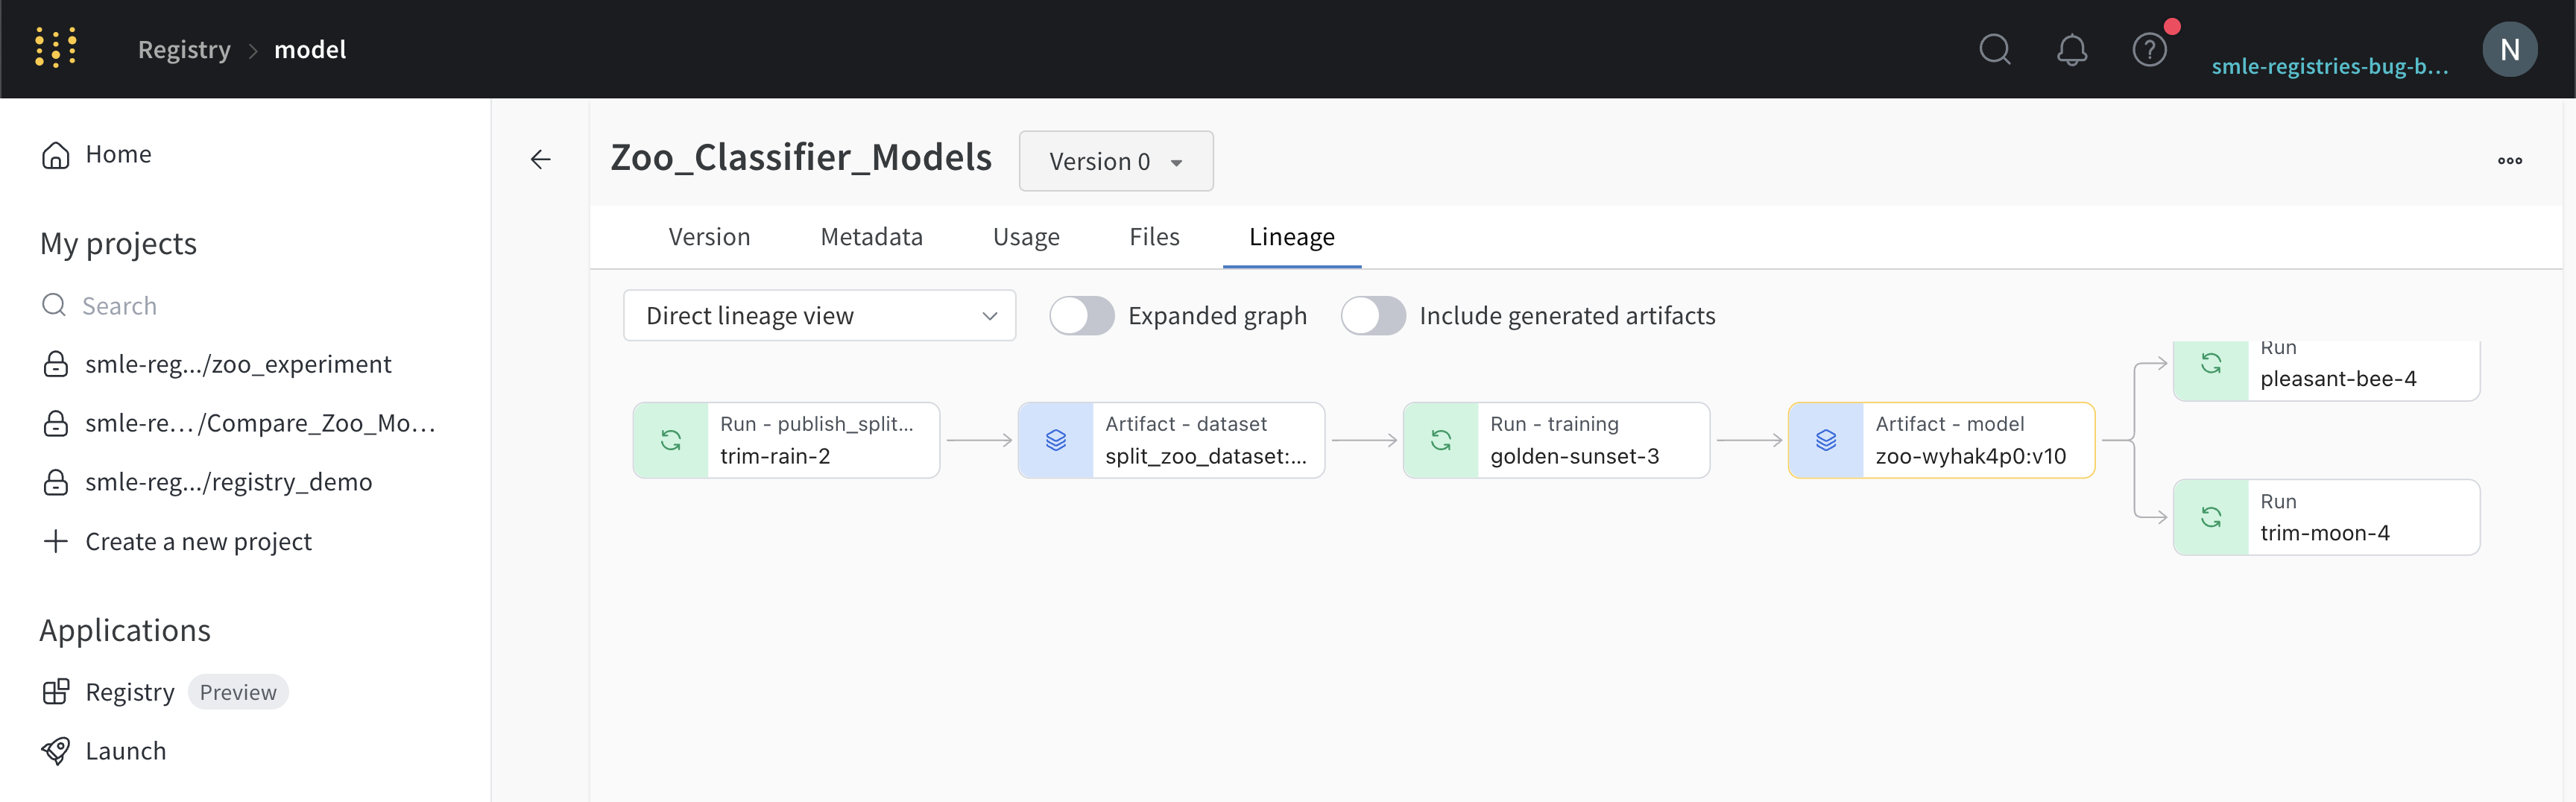

To view the lineage map of an artifact in a registry:

1. Navigate to the Registry app at https://wandb.ai/registry
2. Click on a registry
3. Select an artifact version 
3. Select the **Lineage** tab

## Download artifacts from registry for inference

For this last section, suppose you are in a different team than the user who uploaded the artifact. You want to retrieve the model and dataset artifact was pushed to the registry and make predictions with a new test set. Your team is called "smle-reg-team-1" (previously the team was "smle-reg-team-2") and your team is working on analyzing zoo models in a project called "Compare_Zoo_Models".


Also suppose that this user has [member role permissions](https://docs.wandb.ai/guides/registry/configure_registry#registry-roles-permissions) which means they can view and download artifacts from our registry.

How can you retrieve the artifacts version that were published by another user in another team? Simple:

1. Get the full name of the artifact version programmatically or interactively with the W&B App UI
2. Use the W&B Python SDK to download the artifacts

#### Interactively get full name of model and dataset artifacts from registry
1. Go to the W&B Registry app at https://wandb.ai/registry/.
2. Select the registry that your artifact is linked to.
3. Click the **View details** button next to the name of the collection with your linked artifact. 
4. Click on the **View** button next to the artifact version. 
5. Within the **Version** tab, copy path listed next to **Full Name**.
6. Paste the full name of the registry for the `artifact_or_name` field in `run.use_artifact()`.

Note: In this example, we happen to know these values, so we'll programmatically create the full name of our model and dataset artifacts published in the registry.

### Get trained model from model registry

In [ ]:
# Create model artifact name
ORG_NAME = "smle-registries-bug-bash"
REGISTRY_NAME = "model"
COLLECTION_NAME = "Zoo_Classifier_Models"
VERSION = 0

model_artifact_name = f"{ORG_NAME}/wandb-registry-{REGISTRY_NAME}/{COLLECTION_NAME}:v{VERSION}"
print(f"Model artifact name: {model_artifact_name}")

In [ ]:
DIFFERENT_TEAM_ENTITY = "smle-reg-team-1"
DIFFERENT_PROJECT = "Compare_Zoo_Models"

run = wandb.init(entity=DIFFERENT_TEAM_ENTITY, project=DIFFERENT_PROJECT)
registry_model = run.use_artifact(artifact_or_name=model_artifact_name)
local_model_path = registry_model.download()

For PyTorch models, we need to redefine our model architecture:

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(in_features=16 , out_features=16),
            nn.Sigmoid(),
            nn.Linear(in_features=16, out_features=7)
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits

loaded_model = NeuralNetwork()
loaded_model.load_state_dict(torch.load(f=local_model_path + "/zoo_wandb.pth"))

### Get test dataset from Dataset registry

Let's get the test dataset from our registry. Similar to the above code block, we will specify the full name of the artifact version we want from our Dataset registry.

In [ ]:
# Create dataset artifact name
ORG_NAME = "smle-registries-bug-bash"
REGISTRY_NAME = "dataset"
COLLECTION_NAME = "zoo-dataset-tensors-split"
VERESION = 0

data_artifact_name = f"{ORG_NAME}/wandb-registry-{REGISTRY_NAME}/{COLLECTION_NAME}:v{VERSION}"
print(f"Dataset artifact name: {data_artifact_name}")

In [ ]:
run = wandb.init(entity=DIFFERENT_TEAM_ENTITY, project=DIFFERENT_PROJECT)
dataset_artifact = run.use_artifact(artifact_or_name=data_artifact_name, type="dataset")
local_dataset_path = dataset_artifact.download()

In [ ]:
# Test data and label filenames
test_data_filename = "zoo_dataset_X_test"
test_labels_filename = "zoo_labels_y_test" 

# Load dataset and labels into notebook
loaded_data = torch.load(f"{local_dataset_path}/{test_data_filename}")
loaded_labels = torch.load(f"{local_dataset_path}/{test_labels_filename}")

run.finish()

### Make predictions with loaded model

In [ ]:
class_labels = {
    0: "Aves",
    1: "Mammalia",
    2: "Reptilia",
    3: "Actinopterygii",
    4: "Amphibia",
    5: "Insecta",
    6: "Crustacea",
}

In [ ]:
outputs = loaded_model(loaded_data)
__, predicted = torch.max(outputs, 1)

These integers don't mean much, let's convert them to return the animal class and store this into a pandas DataFrame for us to compare the predicted vs the true values:

In [ ]:
results = list(map(lambda x: class_labels.get(x), predicted.numpy()))
true_values = list(map(lambda x: class_labels.get(x), loaded_labels.squeeze().numpy()))

# Create pandas DataFrame
df = pd.DataFrame(
    {
        'Predicted': results,
        'True values': true_values
    }
)

# Create new column where we compare the predicted vs true
df["Predicted correctly"] = df["Predicted"] == df["True values"]

In [ ]:
df.head()

In [ ]:
# Count how many predictions were wrong
df['Predicted correctly'].value_counts()

In [ ]:
# # Count how many predictions were wrong
# count_false = (~df['Predicted correctly']).sum()
# print("The number of incorrect guesses on test set is:", count_false) 

In [ ]:
# ?? Track these predictions into a project???
# run = wandb.init(entity=DIFFERENT_TEAM_ENTITY, project=DIFFERNT_PROJECT)
# run.finish()